In [104]:
import os
import pandas as pd
import time
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import time

In [3]:
with open("/Users/akhileshgotmare/Downloads/res.json") as file:
    data = pd.read_json(file)
print(data.shape)
data.head()

(213873, 17)


,asin,brand,categories,description,helpful,imUrl,overall,price,related,reviewText,reviewTime,reviewerID,reviewerName,salesRank,summary,title,unixReviewTime
0,B0009YJ238,Nestle,"[[Pet Supplies, Dogs, Treats, Cookies, Biscuit...","Busy Bone, 7 OZ, Small/Medium Dog Treat, Twist...","[0, 0]",http://ecx.images-amazon.com/images/I/31ToYepJ...,5,3.49,NaN,"I adore my six-month-old dog, Midge. She's ev...","01 22, 2007",A3MTXMDJ7JQSFO,A. Ruminski,{'Pet Supplies': 487454},Busy bone = happy owner,BusyBone MED Dog Treat,1169424000
1,B00126U31C,Swatch,"[[Clothing, Shoes & Jewelry, New Arrivals], [C...",NaN,"[0, 1]",http://ecx.images-amazon.com/images/I/51fwuvsL...,3,72.14,"{'also_viewed': ['B002DQGUI0', 'B000KNE09E', '...","The watch itself is solid, however, the leathe...","12 14, 2012",AYKBRA7MKIPAV,G.Jackson,{'Watches': 95452},Swatch watch,Swatch Men's STYNS421 Wild Roar Brown Dial Watch,1355443200
2,B002HHGF5I,Tissot,"[[Sports & Outdoors, Accessories, Sport Watche...",NaN,"[4, 5]",http://ecx.images-amazon.com/images/I/516lmovC...,5,846.00,"{'also_viewed': ['B0029SJ3ZE', 'B001CBC2I4', '...",incredible watch. super light yet rugged. i ...,"03 7, 2011",A3MBOY1IA8PS85,"M. Klein ""Gras""",{'Watches': 27798},great watch,Tissot Men's T0134204405700 T-Touch Expert Pil...,1299456000
3,B002HHGF5I,Tissot,"[[Sports & Outdoors, Accessories, Sport Watche...",NaN,"[8, 11]",http://ecx.images-amazon.com/images/I/516lmovC...,5,846.00,"{'also_viewed': ['B0029SJ3ZE', 'B001CBC2I4', '...",I have been a watch junkie for some years but ...,"02 27, 2010",A1SE5JXA03WBDT,"Mem Ber ""me""",{'Watches': 27798},the best watch in my collection,Tissot Men's T0134204405700 T-Touch Expert Pil...,1267228800
4,B002HHGF5I,Tissot,"[[Sports & Outdoors, Accessories, Sport Watche...",NaN,"[0, 2]",http://ecx.images-amazon.com/images/I/516lmovC...,5,846.00,"{'also_viewed': ['B0029SJ3ZE', 'B001CBC2I4', '...",just what I wanted when I ordered this watch. ...,"01 7, 2014",A4ACF44TDCIZK,MELANIE DAVID,{'Watches': 27798},Tissot Men's T0134204405700 T-Touch Expert Pil...,Tissot Men's T0134204405700 T-Touch Expert Pil...,1389052800


If we inspect some entries, it can be seen that the category column for some of the rows contains more than one entries. See example below

In [4]:
data['categories'][1]

[['Clothing, Shoes & Jewelry', 'New Arrivals'],
 ['Clothing, Shoes & Jewelry', 'Jewelry: International Shipping Available'],
 ['Clothing, Shoes & Jewelry', 'Fashion Watches'],
 ['Clothing, Shoes & Jewelry', 'Available for International Shipping'],
 ['Clothing, Shoes & Jewelry', 'Swatch Watches'],
 ['Clothing, Shoes & Jewelry', 'Men', 'Watches', 'Wrist Watches']]

We figure out the number of such entries (that we call invalid) in our dataset

In [5]:
data['flag'] = data['categories'].apply(lambda x: False if len(x)>1 else True)
print(data.flag.value_counts())
print('Number of invalid entries: ', data.flag.value_counts()[0] ,'\n',
      'Percentage of total entries that are invalid: ',
      100*data.flag.value_counts()[0] / data.flag.value_counts().sum())

True     205354
False      8519
Name: flag, dtype: int64
Number of invalid entries:  8519 
 Percentage of total entries that are invalid:  3.98320498614


In [6]:
df = data[data['flag']].copy()

We intend to perform the category-wise analysis of our reviews and since these entries (that are slightly complicated to handle due to multiple values for category attribute) happen to be only 4% of the entire dataset, we drop them.

In [7]:
print(df['categories'][154])

[['Home & Kitchen', 'Kitchen & Dining', 'Small Appliances', 'Juicers', 'Masticating Juicers']]


Our objective now is to determine a level in the hierarchy of categories where we should stop, so that the different number of categories we get are manageable for analysis and for interpretable results. 

For example the categories attribute for the 154-th instance printed above is a 5 member list -  
['Home & Kitchen', 'Kitchen & Dining', 'Small Appliances', 'Juicers', 'Masticating Juicers']

If we decide to stop at a hierarchy level of 1, we would clip this list to simply ['Home & Kitchen'] or if we stop at the second level we'll end up with ['Home & Kitchen', 'Kitchen & Dining'] for this instance. A good choice of what level to stop at will be guided by the number of unique category attributes we have to deal with for the given level. To begin with, we stop at a level of 2 to realize that we get 103 unique categories which are too much for proper interpretability, hence we go up the level and check for 1.

In [8]:
df_test = df.copy()
df_test['categories_clipped'] = df_test['categories'].apply(lambda x: (x[0][0] + ', ' + x[0][1]) if len(x[0])>2 
                                                            else x[0][0] )
print('Number of unique categories after clipping:', len(df_test.categories_clipped.unique()),
      '\n',df_test.categories_clipped.value_counts())

Number of unique categories after clipping: 103 
 Electronics, Computers & Accessories                      115573
Home & Kitchen, Kitchen & Dining                           16791
Electronics, Accessories & Supplies                        13398
Sports & Outdoors, Outdoor Gear                            11695
Video Games, PC                                             9868
Grocery & Gourmet Food                                      8214
Electronics, Portable Audio & Video                         7233
Cell Phones & Accessories, Accessories                      2753
Health & Personal Care, Personal Care                       1749
Tools & Home Improvement, Power & Hand Tools                1532
Beauty, Skin Care                                           1439
Office Products, Office Electronics                         1413
Electronics, Home Audio                                     1270
Clothing, Shoes & Jewelry, Luggage & Travel Gear            1055
Computers                               

In [9]:
df['categories_clipped'] = df['categories'].apply(lambda x: x[0][0])

In [10]:
print(df['categories_clipped'][154])

Home & Kitchen


As shown in the cell below, if we simply clip to level 1, we get 25 unique categories where 12 of them have less than 1000 reviews. In our further steps we stick to the only 13 categories that have atleast 1000 reviews, so that our claims are not based on small number of reviews.

In [11]:
print('Number of unique categories after clipping:', len(df.categories_clipped.unique()),
      '\n','Number of unique categories with more than 1000 reviews:',
      (df.categories_clipped.value_counts() > 1000).value_counts()[1],
      '\n',df.categories_clipped.value_counts())

Number of unique categories after clipping: 25 
 Number of unique categories with more than 1000 reviews: 13 
 Electronics                  137816
Home & Kitchen                16935
Sports & Outdoors             13772
Video Games                   10569
Grocery & Gourmet Food         8375
Health & Personal Care         3722
Cell Phones & Accessories      2807
Beauty                         1921
Clothing, Shoes & Jewelry      1766
Tools & Home Improvement       1567
Office Products                1561
Pet Supplies                   1247
Computers                      1039
Patio, Lawn & Garden            580
Kitchen & Dining                419
Baby Products                   385
Automotive                      293
Toys & Games                    227
Industrial & Scientific         207
Amazon Fashion                   58
Arts, Crafts & Sewing            35
All Electronics                  33
Office & School Supplies         12
Baby                              5
All Beauty               

We intend to analyze the variations of ratings for these different categories over periods of time since we also access to the time of the review. Let's begin with printing the average ratings obtained for these categories.

In [12]:
for category_name in df.categories_clipped.unique():
    print('Average rating for ', category_name, df[df['categories_clipped'] == category_name].overall.mean())

Average rating for  Pet Supplies 4.097834803528468
Average rating for  Home & Kitchen 4.493888396811338
Average rating for  Grocery & Gourmet Food 4.248238805970149
Average rating for  Electronics 4.2147863818424565
Average rating for  Sports & Outdoors 4.627795527156549
Average rating for  Health & Personal Care 4.377753895754971
Average rating for  Beauty 4.374804789172306
Average rating for  Automotive 4.09556313993174
Average rating for  Clothing, Shoes & Jewelry 4.253114382785957
Average rating for  Tools & Home Improvement 4.271857051691129
Average rating for  Baby 4.6
Average rating for  Video Games 4.0702053174377895
Average rating for  Cell Phones & Accessories 4.391877449234058
Average rating for  Patio, Lawn & Garden 4.612068965517241
Average rating for  Amazon Fashion 4.327586206896552
Average rating for  Toys & Games 4.079295154185022
Average rating for  Office Products 4.470211402946829
Average rating for  Computers 4.468719923002888
Average rating for  Arts, Crafts & Sew

In [13]:
df

,asin,brand,categories,description,helpful,imUrl,overall,price,related,reviewText,reviewTime,reviewerID,reviewerName,salesRank,summary,title,unixReviewTime,flag,categories_clipped
0,B0009YJ238,Nestle,"[[Pet Supplies, Dogs, Treats, Cookies, Biscuit...","Busy Bone, 7 OZ, Small/Medium Dog Treat, Twist...","[0, 0]",http://ecx.images-amazon.com/images/I/31ToYepJ...,5,3.49,NaN,"I adore my six-month-old dog, Midge. She's ev...","01 22, 2007",A3MTXMDJ7JQSFO,A. Ruminski,{'Pet Supplies': 487454},Busy bone = happy owner,BusyBone MED Dog Treat,1169424000,True,Pet Supplies
14,B0032XEIOG,Omega,"[[Home & Kitchen, Kitchen & Dining, Small Appl...",,"[1, 1]",http://ecx.images-amazon.com/images/I/41qaprBJ...,4,107.91,"{'also_bought': ['0761511261', '0778801810', '...",I bought this juicer after seeing the document...,"06 18, 2013",A37H1QYUEF7SIG,Michael Gomez,{'Kitchen & Dining': 15042},Wonderful but messy,Omega BMJ330 Commercial 350-Watt Stainless-Ste...,1371513600,True,Home & Kitchen
15,B0032XEIOG,Omega,"[[Home & Kitchen, Kitchen & Dining, Small Appl...",,"[4, 5]",http://ecx.images-amazon.com/images/I/41qaprBJ...,4,107.91,"{'also_bought': ['0761511261', '0778801810', '...","I have had several juicers over the years, LeQ...","11 15, 2013",A10JXDL2D6SKYQ,mplieb,{'Kitchen & Dining': 15042},Very Good Juicer.,Omega BMJ330 Commercial 350-Watt Stainless-Ste...,1384473600,True,Home & Kitchen
16,B0032XEIOG,Omega,"[[Home & Kitchen, Kitchen & Dining, Small Appl...",,"[5, 5]",http://ecx.images-amazon.com/images/I/41qaprBJ...,5,107.91,"{'also_bought': ['0761511261', '0778801810', '...","works great,love it :) the price was great. ...","01 23, 2013",A39G2TTVI4W5CR,mary dougherty,{'Kitchen & Dining': 15042},juicer,Omega BMJ330 Commercial 350-Watt Stainless-Ste...,1358899200,True,Home & Kitchen
17,B0032XEIOG,Omega,"[[Home & Kitchen, Kitchen & Dining, Small Appl...",,"[1, 3]",http://ecx.images-amazon.com/images/I/41qaprBJ...,5,107.91,"{'also_bought': ['0761511261', '0778801810', '...",This was ordered as a Christmas gift. It arri...,"01 17, 2012",A10VAS5VRBOEO0,v.l.jones,{'Kitchen & Dining': 15042},love my juicer!,Omega BMJ330 Commercial 350-Watt Stainless-Ste...,1326758400,True,Home & Kitchen
18,B0032XEIOG,Omega,"[[Home & Kitchen, Kitchen & Dining, Small Appl...",,"[4, 4]",http://ecx.images-amazon.com/images/I/41qaprBJ...,1,107.91,"{'also_bought': ['0761511261', '0778801810', '...",I bought this as a Xmas gift to myself. I had...,"03 13, 2014",A3F17AKPC823Z4,Mathias j Dore Jr,{'Kitchen & Dining': 15042},Terrible,Omega BMJ330 Commercial 350-Watt Stainless-Ste...,1394668800,True,Home & Kitchen
19,B0032XEIOG,Omega,"[[Home & Kitchen, Kitchen & Dining, Small Appl...",,"[1, 2]",http://ecx.images-amazon.com/images/I/41qaprBJ...,3,107.91,"{'also_bought': ['0761511261', '0778801810', '...",This one is $199 on the Juice Lady's site. I g...,"11 20, 2013",A12EMELDBQ0258,Lynn Buquoi,{'Kitchen & Dining': 15042},"It's ok. Wouldn't buy it again, but good for n...",Omega BMJ330 Commercial 350-Watt Stainless-Ste...,1384905600,True,Home & Kitchen
20,B0032XEIOG,Omega,"[[Home & Kitchen, Kitchen & Dining, Small Appl...",,"[0, 1]",http://ecx.images-amazon.com/images/I/41qaprBJ...,5,107.91,"{'also_bought': ['0761511261', '0778801810', '...",Everything about this Juicer is Great. No prob...,"07 7, 2013",A3FW1ENVPJO0MC,Nancy m Hines,{'Kitchen & Dining': 15042},Works Great!!!,Omega BMJ330 Commercial 350-Watt Stainless-Ste...,1373155200,True,Home & Kitchen
21,B0032XEIOG,Omega,"[[Home & Kitchen, Kitchen & Dining, Small Appl...",,"[2, 5]",http://ecx.images-amazon.com/images/I/41qaprBJ...,1,107.91,"{'also_bought': ['0761511261', '0778801810', '...","Ok the second time I used this, the black plas...","10 1, 2013",A1324Q3TRHLJCV,"oB ""Chef 777""",{'Kitchen & Dining': 15042},Threw it out.,Omega BMJ330 Commercial 350-Watt Stainless-Ste...,1380585600,True,Home & Kitchen
22,B0032XEIOG,Omega,"[[Home & Kitchen, Kitchen & Dining, Small Appl...",,"[3, 4]",http://ecx.images-amazon.com/images/I/41qapr

In [14]:
import datetime as dt
print(dt.datetime.utcfromtimestamp(df.unixReviewTime[21]).strftime("%Y/%m/%d %H:%M"),
dt.datetime.utcfromtimestamp(df.unixReviewTime[213872]).strftime("%Y/%m/%d %H:%M"),
dt.datetime.utcfromtimestamp(df.unixReviewTime[37]).strftime("%Y/%m/%d %H:%M"))

2013/10/01 00:00 2014/02/12 00:00 2013/07/18 00:00


As it turns out, all the unixtime values transform to '00:00' hours with the date matching to the column 'reviewTime', unfortunately the 'unixReviewTime' does not provide additional information for the time of the day when the review was made.

We now play with one of the category ('Home & Kitchen') and analyze the variations of rating over time for this category.

In [142]:
category_list = []
for category in df.categories_clipped.value_counts().index:
#     if (df.categories_clipped.value_counts()[category] > 1000):
    category_list.append(category)
category_list

['Electronics',
 'Home & Kitchen',
 'Sports & Outdoors',
 'Video Games',
 'Grocery & Gourmet Food',
 'Health & Personal Care',
 'Cell Phones & Accessories',
 'Beauty',
 'Clothing, Shoes & Jewelry',
 'Tools & Home Improvement',
 'Office Products',
 'Pet Supplies',
 'Computers',
 'Patio, Lawn & Garden',
 'Kitchen & Dining',
 'Baby Products',
 'Automotive',
 'Toys & Games',
 'Industrial & Scientific',
 'Amazon Fashion',
 'Arts, Crafts & Sewing',
 'All Electronics',
 'Office & School Supplies',
 'Baby',
 'All Beauty']

In [145]:
category_list

['Electronics',
 'Home & Kitchen',
 'Sports & Outdoors',
 'Video Games',
 'Grocery & Gourmet Food',
 'Health & Personal Care',
 'Cell Phones & Accessories',
 'Beauty',
 'Clothing, Shoes & Jewelry',
 'Tools & Home Improvement',
 'Office Products',
 'Pet Supplies',
 'Computers',
 'Patio, Lawn & Garden',
 'Kitchen & Dining',
 'Baby Products',
 'Automotive',
 'Toys & Games',
 'Industrial & Scientific',
 'Amazon Fashion',
 'Arts, Crafts & Sewing',
 'All Electronics',
 'Office & School Supplies',
 'Baby',
 'All Beauty']

In [146]:
refined_category_list = ['Electronics',
 'Home & Kitchen',
 'Sports & Outdoors',
 'Video Games',
 'Grocery & Gourmet Food',
 'Health & Personal Care',
#  'Cell Phones & Accessories',
 'Beauty',
#  'Clothing, Shoes & Jewelry',
 'Tools & Home Improvement',
 'Office Products',
#  'Pet Supplies',
#  'Computers',
#  'Patio, Lawn & Garden',
 'Kitchen & Dining',
#  'Baby Products',
#  'Automotive',
#  'Toys & Games',
#  'Industrial & Scientific',
#  'Amazon Fashion',
#  'Arts, Crafts & Sewing',
#  'All Electronics',
#  'Office & School Supplies',
#  'Baby',
#  'All Beauty'
                        ]

Category:  Electronics


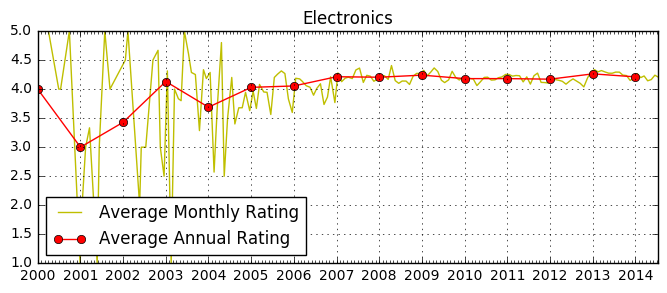

Category:  Home & Kitchen


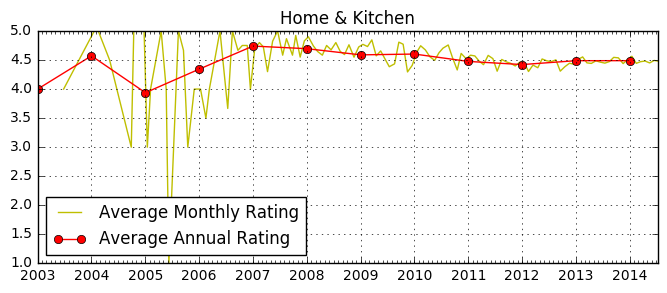

Category:  Sports & Outdoors


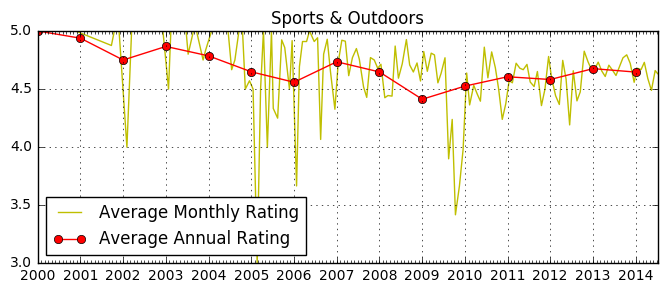

Category:  Video Games


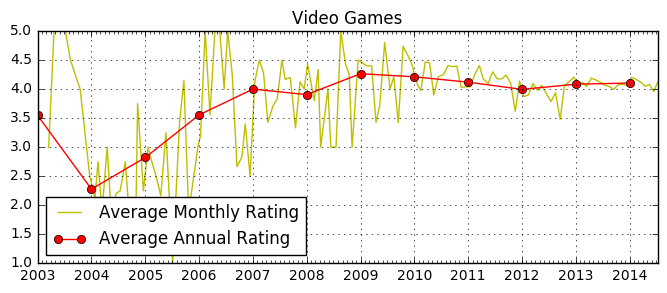

Category:  Grocery & Gourmet Food


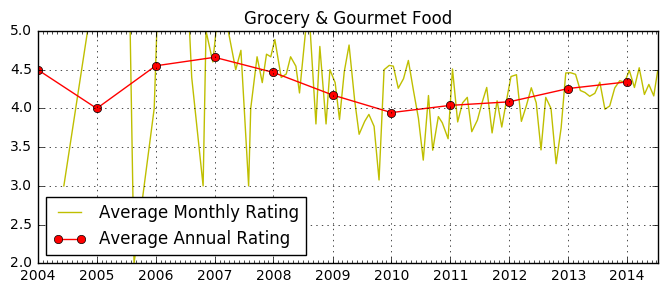

Category:  Health & Personal Care


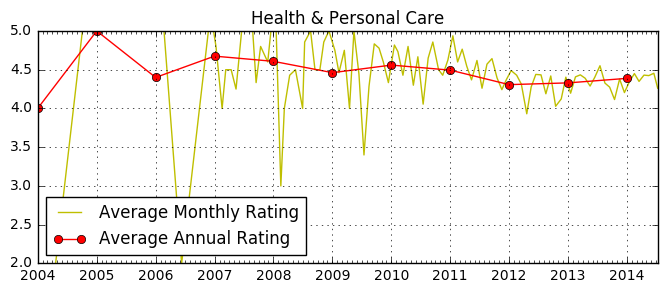

Category:  Beauty


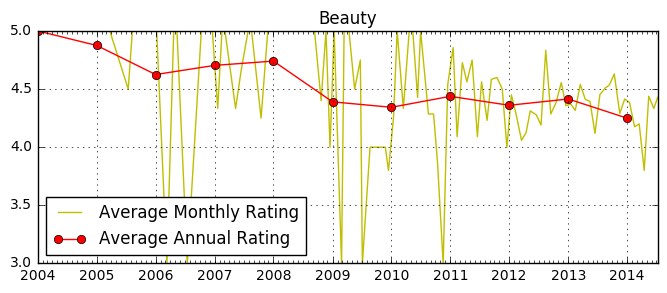

Category:  Tools & Home Improvement


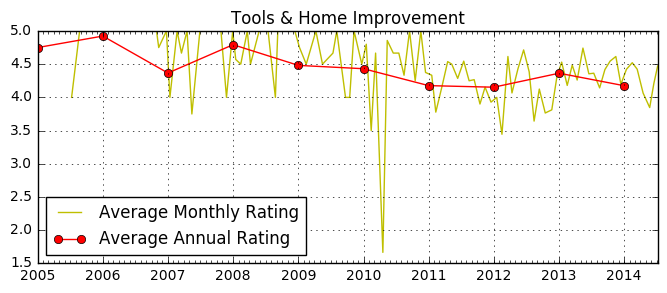

Category:  Office Products


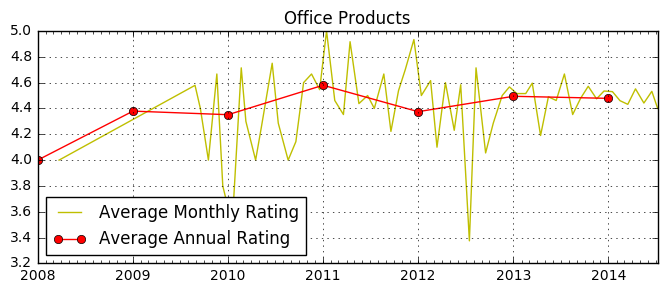

Category:  Kitchen & Dining


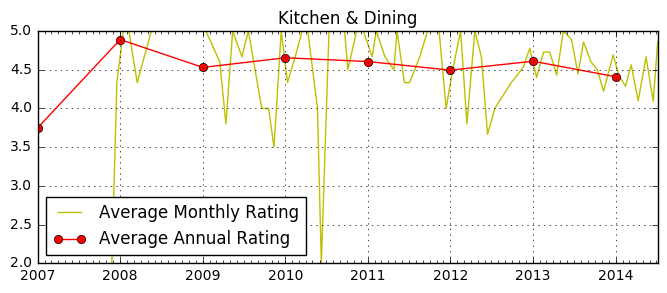

In [149]:
for category_name in refined_category_list:
    print('Category: ',category_name)
    eg = df[df['categories_clipped'] == category_name].copy()
    eg.sort_values( 'unixReviewTime', axis=0,inplace = True)
    eg['reviewMonth'] = ((eg.unixReviewTime).map(lambda t: datetime.fromtimestamp(t).month))
    eg['reviewYear']  = ((eg.unixReviewTime).map(lambda t: datetime.fromtimestamp(t).year))

    hor_axis = []

    for index in eg.groupby(['reviewYear']).mean()['unixReviewTime'].index:
        Y = eg.groupby(['reviewYear']).mean()['unixReviewTime'].map(lambda t: datetime.fromtimestamp(t))[index].year
        dt = datetime(year=Y, month=1, day=1)
        new_year_day = time.mktime(dt.timetuple())
        hor_axis.append(datetime.fromtimestamp(new_year_day))

    plt.rcParams["figure.figsize"] = [8,3]

    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')

    fig, ax = plt.subplots()
    ax.plot( eg.groupby(['reviewYear','reviewMonth']).mean()['unixReviewTime'].map
             (lambda t: datetime.fromtimestamp(t)),
             eg.groupby(['reviewYear','reviewMonth']).mean()['overall'],'y',label='Average Monthly Rating')

    ax.plot(hor_axis

    #     eg.groupby(['reviewYear']).mean()['unixReviewTime'].map
    #         (lambda t: datetime.fromtimestamp(t))
            , eg.groupby(['reviewYear']).mean()['overall'],'ro-',label='Average Annual Rating')


    # format the ticks
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)
    ax.grid(True)
    plt.title((category_name))
    plt.legend(loc='lower left')
    plt.show()

In [ ]:
input_names = (data.reviewerName.values[:1000])

In [ ]:
import requests
import json

def name_to_ethnicity(names):
    req = requests.post("http://www.textmap.com/ethnicity_api/api", data=json.dumps({"names": names}))
    return req.json()
names = ["Narendra Modi", "Thomas Hoffman"]
result = name_to_ethnicity(names)
print(name_to_ethnicity(names))


In [ ]:
input_names

In [ ]:
import pickle
l = input_names
with open("test_amazon.txt", "wb") as fp:
    pickle.dump(l, fp)

In [ ]:
with open ('test_amazon.txt', 'rb') as fp:
    itemlist = pickle.load(fp)

In [ ]:
result[names[0]][0]['best']

In [ ]:
data.reviewerName.isnull().value_counts()

In [ ]:
((213873/6) * 5)/3600 

In [ ]:
division = 100
ethnicity = []
for i in range(int(len(data.reviewerName)/division)+1):
    begin = datetime.now()
    print(i)
    if i == len(data.reviewerName)/division:
        names = list(data.reviewerName.values[division*i:-1])
        ethnicity.append(name_to_ethnicity(names))
    else:
        names = list(data.reviewerName.values[division*i:division*(i+1)])
        ethnicity.append(name_to_ethnicity(names))
    time.sleep(45)
    end = datetime.now()
    execution_time_iter = (begin - end).total_seconds()
    print("execution time = {t:.3f} seconds".format(t=execution_time_iter))

In [ ]:
import datetime
print(
    datetime.datetime.fromtimestamp(
        int("1284101485")
    ).strftime('%Y-%m-%d %H:%M:%S')
)

In [ ]:
sorted_sub_data.unixReviewTime.values

In [ ]:
data.head()

In [ ]:
data.shape[0]/100 * 7

In [ ]:
data.overall.isnull().value_counts()

In [ ]:
review_series = data.reviewText
data.reviewText.isnull().value_counts()[False]

In [ ]:
review_series

In [ ]:
# categories are like [[Health & Personal Care,...]], we are making them be "Health & Personal Care,..." 
def convert_cat():
    s = data["categories"]
    val = []
    for l in list(s): val.append("".join(l[0]))
    s_new = pd.Series(val, s.index.values)
    data["categories"]=s_new
convert_cat()

In the next few cells delete products with same name as swiss brands, but they represent actually other brand.

In [ ]:
data=data[data['brand']!="ABB"]
data=data[data['brand']!="Callebaut"]
data.shape

In [ ]:
data=data[(data['brand']!="IWC")|((data['brand']=="IWC") & \
                    ((data["categories"]!="AutomotivePaint, Body & TrimBodyDoors")& \
                                (data["categories"]!='AutomotiveTires & WheelsAccessoriesCenter Caps')& \
                                    (data["categories"]!='AutomotiveTires & WheelsHubcaps & CoversHubcaps')))]

In [ ]:
data=data[(data['brand']!="Swatch")|((data['brand']=="Swatch") & \
                    ((data["categories"]!="Arts, Crafts & SewingFabric")& \
                                    (data["categories"]!='Arts, Crafts & SewingNeedleworkCross-StitchCounted Kits')))]

In [ ]:
data=data[(data['brand']!="Sigg")|((data['brand']=="Sigg") & \
                                    (data["categories"]!='Office ProductsOffice & School SuppliesForms, Recordkeeping & Money HandlingMoney & Rent Receipts'))]

In [ ]:
data=data[(data['brand']!="PB Swiss")|((data['brand']=="PB Swiss") & \
                    ((data["categories"]!="Clothing, Shoes & JewelryNovelty, Costumes & MoreNoveltyJewelryBracelets")& \
                                (data["categories"]!='Office ProductsOffice & School SuppliesCalendars, Planners & Personal OrganizersWall Calendars')& \
                                    (data["categories"]!='Sports & OutdoorsAccessoriesWristbands')))]

In [ ]:
data=data[(data['brand']!="Omega")|((data['brand']=="Omega") & \
                    ((data["categories"]=="Clothing, Shoes & JewelryGifts")| \
                    (data["categories"]=='Clothing, Shoes & JewelryJewelry: International Shipping Available')| \
                    (data["categories"]=='Clothing, Shoes & JewelryLuxury Watches')| \
                     (data["categories"]=='Clothing, Shoes & JewelryNew Arrivals')| \
                     (data["categories"]=='Clothing, Shoes & JewelryOmega Watches')| \
                     (data["categories"]=='Sports & OutdoorsAccessoriesSport Watches')))]